## Import

In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import pandas_datareader.data as pdr
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pywt
import talib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 분석 시점은 2013년 10월부터 2023년 6월까지로 설정한다.
start, end = '2013-10-01', '2023-07-02'

- #### 주식 데이터
  Microsoft, Amazon, Intel, McDonald, Apple 주식을 수집한다.

In [3]:
msft = fdr.DataReader('MSFT', start, end)
amzn = fdr.DataReader('AMZN', start, end)
intc = fdr.DataReader('INTC', start, end)
mcd = fdr.DataReader('MCD', start, end)    
aapl = fdr.DataReader('AAPL', start, end)
display(msft)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-01,33.349998,33.610001,33.299999,33.580002,28.120390,36718700
2013-10-02,33.360001,34.029999,33.290001,33.919998,28.405102,46946800
2013-10-03,33.880001,34.000000,33.419998,33.860001,28.354862,38703800
2013-10-04,33.689999,33.990002,33.619999,33.880001,28.371611,33008100
2013-10-07,33.599998,33.709999,33.200001,33.299999,27.885916,35069300
...,...,...,...,...,...,...
2023-06-26,333.720001,336.109985,328.489990,328.600006,327.905762,21520600
2023-06-27,331.859985,336.149994,329.299988,334.570007,333.863159,24354100
2023-06-28,334.660004,337.980011,333.809998,335.850006,335.140442,20259500


- #### 경제지표
GDP(국내총생산), CPI(소비자물가지수), PPI(생산자물가지수), 실업률, 3년금리, 환율,<br>
소매 판매 지수, 무역 수지, S&P500의 변동지수, 나스닥, 원유가격, S&P500, SOX(반도체지수)
   - 경기선행지수는 결측치로 제외한다.

In [4]:
econ = ['GDP', 'CPIAUCNS', 'PPIACO', 'UNRATE', 'GS3', 'DEXUSEU', 
        'RSAFS', 'NETEXC', 'VIXCLS', 'NASDAQCOM', 'DCOILWTICO']

economics = pd.DataFrame({'DATE': pd.date_range('2013-10-01','2023-07-01')})
for code in econ:
    economics = economics.merge(pdr.DataReader(code, 'fred', start, end), on='DATE', how='left')

In [5]:
# S&P500, SOX(반도체지수)는 별도로 수집한다.
economics = economics.merge(pd.concat([fdr.DataReader('S&P500', start, end)['Adj Close'], 
                                       yf.download("^SOX", start, end)['Adj Close']], axis=1).reset_index(),
                            left_on='DATE', right_on='Date', how='left')
economics.set_index('DATE', inplace=True)
economics.drop(['Date'], axis=1, inplace=True)
economics.columns=['GDP','CPI','PPI','UNRATE', 'IR', 'ER', 'RS', 'TB', 'VIX', 'NASDAQ', 'OP', 'SP500', 'SOX']
economics = economics.fillna(method='backfill')
display(economics)

[*********************100%%**********************]  1 of 1 completed


,GDP,CPI,PPI,UNRATE,IR,ER,RS,TB,VIX,NASDAQ,OP,SP500,SOX
DATE,,,,,,,,,,,,,
2013-10-01,17192.019,233.546,202.500,7.2,0.63,1.3534,419288.0,-275.552,15.54,3817.98,102.09,1695.000000,495.769989
2013-10-02,17197.738,233.069,201.200,6.9,0.58,1.3592,420468.0,-329.736,16.60,3815.02,104.15,1693.869995,495.100006
2013-10-03,17197.738,233.069,201.200,6.9,0.58,1.3642,420468.0,-329.736,17.67,3774.34,103.29,1678.660034,493.799988
2013-10-04,17197.738,233.069,201.200,6.9,0.58,1.3582,420468.0,-329.736,16.74,3807.75,103.83,1690.500000,497.720001
2013-10-05,17197.738,233.069,201.200,6.9,0.58,1.3569,420468.0,-329.736,19.41,3770.38,103.07,1676.119995,495.089996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,27623.543,305.691,253.889,3.5,4.47,1.0961,694415.0,-937.655,13.74,13555.67,67.68,4378.410156,3642.409912
2023-06-28,27623.543,305.691,253.889,3.5,4.47,1.0904,694415.0,-937.655,13.43,13591.75,69.54,4376.859863,3609.479980
2023-06-29,27623.543,305.691,253.889,3.5,4.47,1.0881,694415.0,-937.655,13.54,13591.33,69.85,4396.439941,3614.179932


- #### 재무제표
  stockanalysis 사이트를 통해 10년치 재무제표를 크롤링한다.

In [6]:
def FS(ticker):
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
    url = f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    element_tables = soup.select("table[data-test='financials']")
    # 매출성장률, EPS 성장률
    growth = ['Revenue Growth (YoY)', 'EPS Growth']
    df = pd.read_html(str(element_tables))[0].rename(columns={'Quarter Ended':'QuarterEnded'}).query('QuarterEnded in @growth')

    url = f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    element_tables = soup.select('html > body')
    # PER, PBR, 부채비율, 당좌비율
    ratio = ['PE Ratio', 'PB Ratio','Debt / Equity Ratio', 'Quick Ratio']
    df = pd.concat([df, 
                    pd.read_html(str(element_tables))[0].rename(columns={'Quarter Ended':'QuarterEnded'}).query('QuarterEnded in @ratio')]).T.iloc[1:]
    df.columns = ['RG', 'EPSG', 'PER', 'PBR', 'DtoE', 'QR']
    df = df.iloc[:-3].reset_index()
    df['Date'] = pd.to_datetime(df['index'])
    df.drop(['index'], axis=1, inplace=True)
    df['RG'] = df['RG'].apply(lambda x: x.replace('%', '') if '%' in x else x.replace('-','0') if len(x)==1 else x)
    df['EPSG'] = df['EPSG'].apply(lambda x: x.replace('%', '') if '%' in x else x.replace('-','0') if len(x)==1 else x)
    return df.applymap(lambda x: np.nan if x=='0' else x).astype(dict(zip(df.columns, ['float']*6)))

In [7]:
msft_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2013-10-01','2023-07-01')}).set_index('Date'),
                     FS('msft').set_index('Date')], axis=1)
msft_fs = msft_fs.fillna(method='backfill')

amzn_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2013-10-01','2023-07-01')}).set_index('Date'), 
                     FS('amzn').set_index('Date')], axis=1)
amzn_fs = amzn_fs.fillna(method='backfill')

intc_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2013-10-01','2023-07-01')}).set_index('Date'), 
                     FS('intc').set_index('Date')], axis=1)
intc_fs = intc_fs.fillna(method='backfill')

mcd_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2013-10-01','2023-07-01')}).set_index('Date'), 
                    FS('mcd').set_index('Date')], axis=1)
mcd_fs = mcd_fs.fillna(method='backfill')

aapl_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2013-10-01','2023-07-01')}).set_index('Date'),
                     FS('aapl').set_index('Date')], axis=1)
aapl_fs = aapl_fs.fillna(method='backfill')

## Feature Generation

- #### 주가 데이터

In [8]:
def StockFeatures(DATA):
    DATA['next_rtn'] = DATA['Close']/DATA['Open'] - 1
    DATA['log_return'] = np.log(1+DATA['Adj Close'].pct_change())
    
    # 이동평균
    DATA['MA5'] = talib.SMA(DATA['Close'], timeperiod=5)
    DATA['RASD5'] = talib.SMA(talib.STDDEV(DATA['Close'], timeperiod=5, nbdev=1), timeperiod=5)
    
    # MACD 지표
    macd, _, _ = talib.MACD(DATA['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    DATA['MACD'] = macd
    
    # 모멘텀 지표
    DATA['CCI'] = talib.CCI(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    
    # 변동성 지표
    DATA['ATR'] = talib.ATR(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    
    # 볼린저 밴드
    upper, middle, lower = talib.BBANDS(DATA['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    DATA['UPPER'] = upper
    DATA['MID'] = middle
    DATA['LOW'] = lower
    
    # MTM
    DATA['MTM1'] = talib.MOM(DATA['Close'], timeperiod=1)
    DATA['MTM3'] = talib.MOM(DATA['Close'], timeperiod=3)
    
    # ROC
    DATA['ROC'] = talib.ROC(DATA['Close'], timeperiod=60)
    
    # Wiliams
    DATA['WPR'] = talib.WILLR(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    return DATA

In [9]:
msft = StockFeatures(msft)
amzn = StockFeatures(amzn)
intc = StockFeatures(intc)
mcd = StockFeatures(mcd)
aapl = StockFeatures(aapl)

## Correlation
- 다섯 기업 모두 변동성이 큰 반면 안정적인 수익률을 보인다.
- Intel은 비교적 주식시장의 움직임과 다른 추세를 보인다.
- 투자자들이 Microsoft와 Apple에 투자할 때 PBR을. McDonald와 Apple에 투자할 때 PER을 많이 고려한다고 유추할 수 있다.
- 실업률은 주가변화에 큰 연관이 없는 변수이다.

In [10]:
msft_tot = msft.reset_index().merge(economics.reset_index(), left_on='Date', right_on='DATE', how='left')\
           .merge(msft_fs.reset_index(), on='Date', how='left')
msft_tot.drop(['DATE'], axis=1, inplace=True)
msft_tot.set_index('Date', inplace=True)

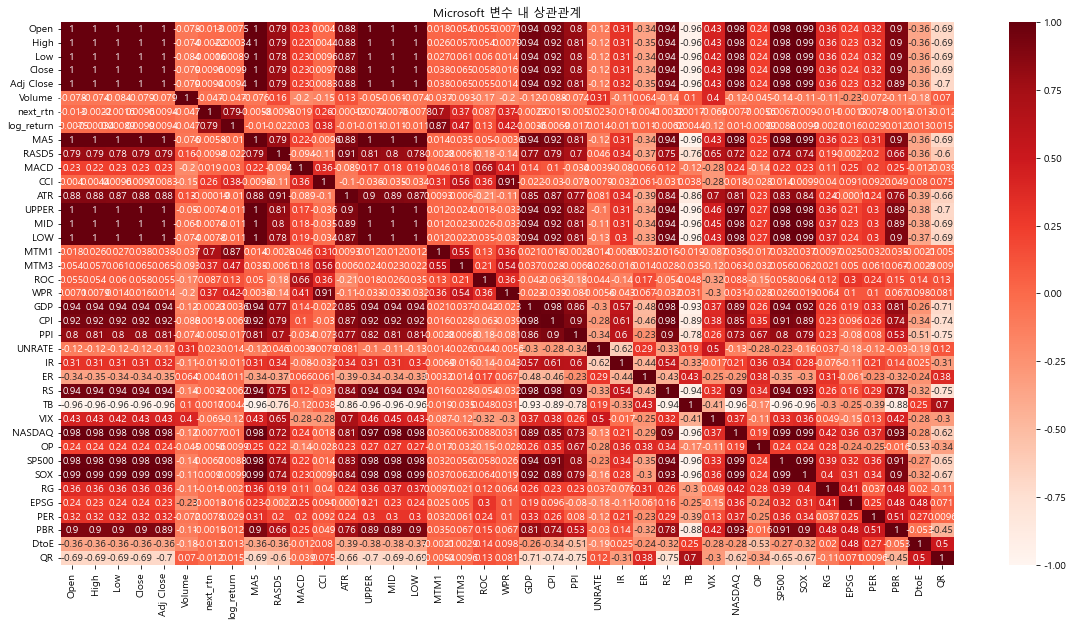

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(msft_tot.corr(), vmin=-1, vmax=1, annot=True, cmap='Reds')
plt.title("Microsoft 변수 내 상관관계")
plt.show()

In [12]:
amzn_tot = amzn.reset_index().merge(economics.reset_index(), left_on='Date', right_on='DATE', how='left')\
           .merge(amzn_fs.reset_index(), on='Date', how='left')
amzn_tot.drop(['DATE'], axis=1, inplace=True)
amzn_tot.set_index('Date', inplace=True)

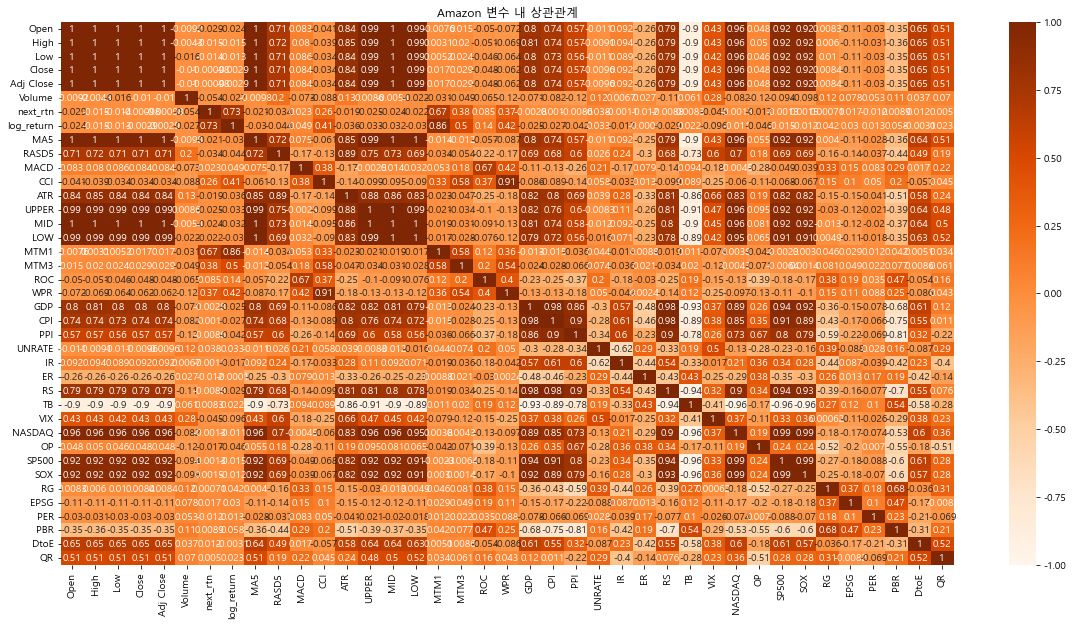

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(amzn_tot.corr(), vmin=-1, vmax=1, annot=True, cmap='Oranges')
plt.title("Amazon 변수 내 상관관계")
plt.show()

In [14]:
intc_tot = intc.reset_index().merge(economics.reset_index(), left_on='Date', right_on='DATE', how='left')\
           .merge(intc_fs.reset_index(), on='Date', how='left')
intc_tot.drop(['DATE'], axis=1, inplace=True)
intc_tot.set_index('Date', inplace=True)

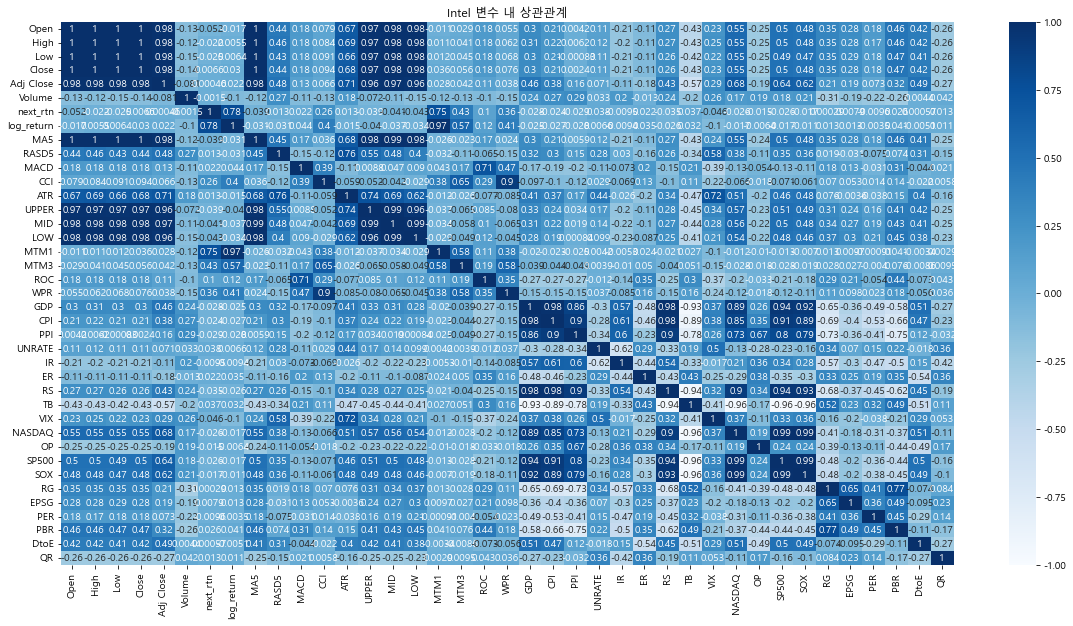

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(intc_tot.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
plt.title("Intel 변수 내 상관관계")
plt.show()

In [16]:
mcd_tot = mcd.reset_index().merge(economics.reset_index(), left_on='Date', right_on='DATE', how='left')\
           .merge(mcd_fs.reset_index(), on='Date', how='left')
mcd_tot.drop(['DATE'], axis=1, inplace=True)
mcd_tot.set_index('Date', inplace=True)

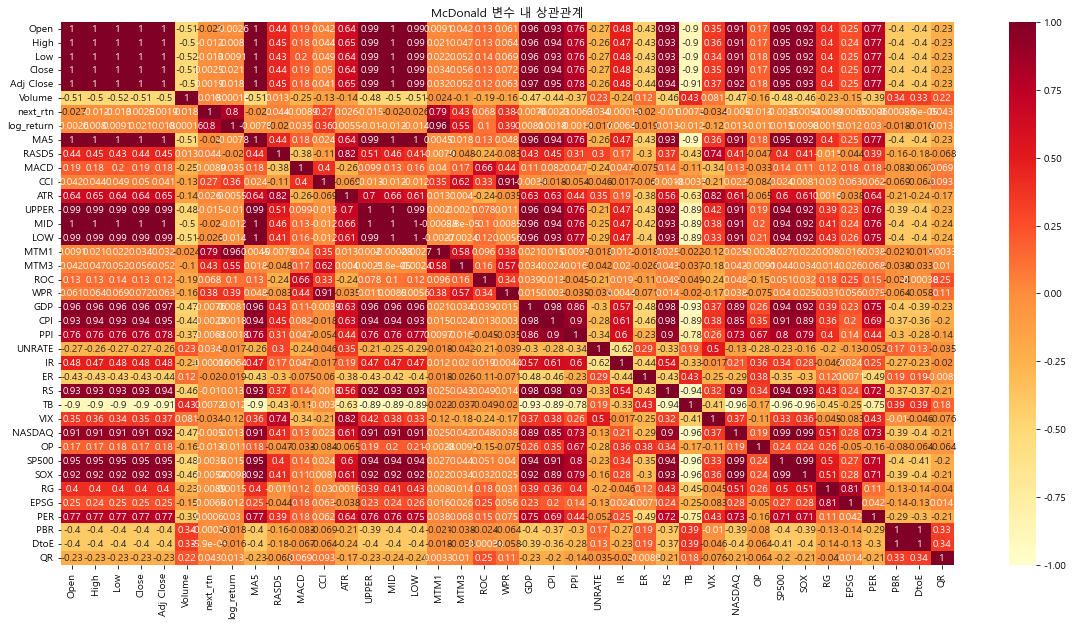

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(mcd_tot.corr(), vmin=-1, vmax=1, annot=True, cmap='YlOrRd')
plt.title("McDonald 변수 내 상관관계")
plt.show()

In [18]:
aapl_tot = aapl.reset_index().merge(economics.reset_index(), left_on='Date', right_on='DATE', how='left')\
           .merge(aapl_fs.reset_index(), on='Date', how='left')
aapl_tot.drop(['DATE'], axis=1, inplace=True)
aapl_tot.set_index('Date', inplace=True)

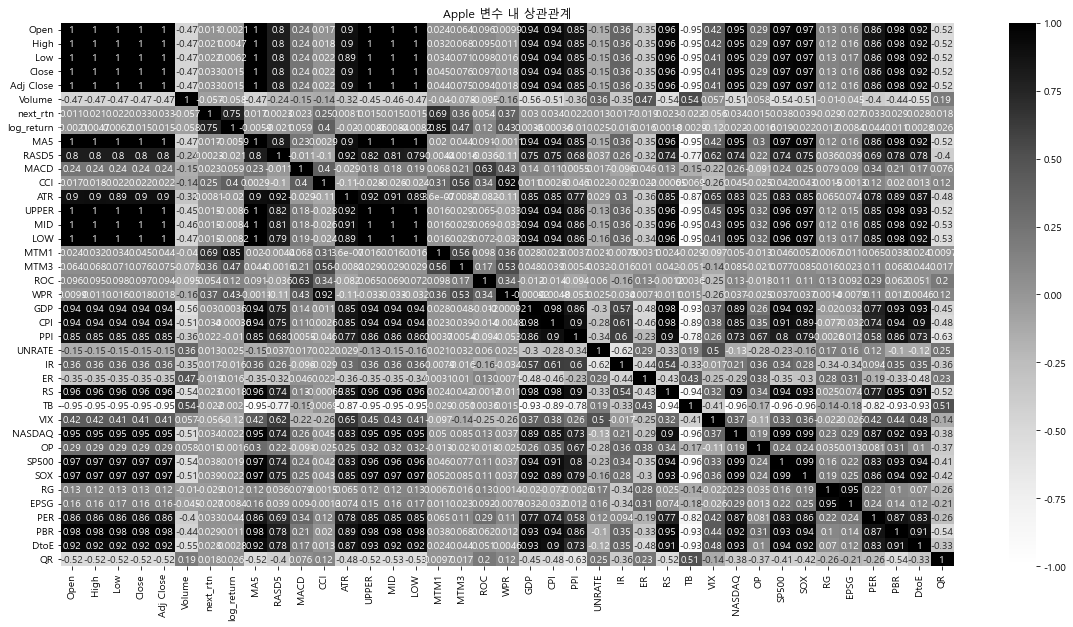

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(aapl_tot.corr(), vmin=-1, vmax=1, annot=True, cmap='Greys')
plt.title("Apple 변수 내 상관관계")
plt.show()